# Subreddit Spam Classifier
#### Web APIs & Classification
_Author: Ritchie Kwan_

---


## Table of Contents

0. [Problem Statement](01-Gathering-Data.ipynb#Problem-Statement)
1. [Data Collection](01-Gathering-Data.ipynb#Data-Collection)
1. [Data Cleaning & EDA](02-Data-Cleaning-and-EDA.ipynb#Data-Cleaning-and-EDA)
1. [Benchmark Model](#Benchmark-Model)
1. [Model Tuning](04-Model-Tuning.ipynb#Model-Tuning)
1. [Evaluation and Conceptual Understanding](04-Model-Tuning.ipynb#Evaluation-and-Conceptual-Understanding)



### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression

from dsi6.metrics import ClassificationMetrics
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [5]:
df = pd.read_csv('../data/leanfire-fatfire_clean.csv')
# df = pd.read_csv('../data/shittylifeprotips-lifeprotips_clean.csv')

In [6]:
df.head()

,title,selftext,comments,subreddit_leanfire
0,"['saving', 'money', 'on', 'food']","['i', 'know', 'food', 'is', 'a', 'general', 't...","['budgetbytes', 'com', 'seconded', 'this', 'is...",1
1,"['transitioning', 'to', 'the', 'next', 'chapte...","['i', 'm', 'in', 'my', 'late', '40', 'and', 'p...","['have', 'you', 'given', 'consideration', 'to'...",0
2,"['26', 'yr', 'old', 'debating', '2', 'career',...","['hey', 'fatfire', 'i', 'would', 'like', 'you'...","['pe', 'without', 'a', 'doubt', 'if', 'you', '...",0
3,"['best', 'banking', 'relationship', 'with', 'a...","['i', 'currently', 'have', 'most', 'of', 'my',...","['bofa', 'merrill', 'edge', 'with', '100k', 'b...",0
4,"['my', 'mom', 'is', 'literally', 'working', 'f...","['my', 'parent', 'are', 'in', 'their', 'late',...","['no', 'reason', 'for', 'what', 'she', 'is', '...",1


### Define X and y

In [7]:
# features = ['title', 'selftext', 'comments']
target = 'subreddit_leanfire'

X = df['title'] + df['selftext'] + df['comments']
y = df[target]

In [8]:
X.head()

0    ['saving', 'money', 'on', 'food']['i', 'know',...
1    ['transitioning', 'to', 'the', 'next', 'chapte...
2    ['26', 'yr', 'old', 'debating', '2', 'career',...
3    ['best', 'banking', 'relationship', 'with', 'a...
4    ['my', 'mom', 'is', 'literally', 'working', 'f...
dtype: object

In [9]:
y.head()

0    1
1    0
2    0
3    0
4    1
Name: subreddit_leanfire, dtype: int64

### Baseline Score

The baseline score assumes all of the data is y=1.

In [10]:
baseline_score = y.value_counts(normalize = True)
print(f'Baseline Score: {baseline_score[1]}')

Baseline Score: 0.5666477595008508


## Benchmark Model

The benchmark model will be a `LogisticRegression` classifier.

### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    random_state = 42)

### Remove Obvious Words

In [12]:
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend(['http', 'www', 'reddit', 'com', 'amp', 'x200b', 
                          'deleted', 'en', 'wikipedia', 'org', 'financialindependence', 
                          'youtube', 'personalfinance', 'comment', 'leanfire', 'fatfire',
                          'financial', 'independence'])
custom_stop_words = list(set(custom_stop_words))

In [36]:
['http', 'www', 'reddit', 'com', 'amp', 'x200b', 
                          'deleted', 'en', 'wikipedia', 'org', 'financialindependence', 
                          'youtube', 'personalfinance', 'comment', 'leanfire', 'fatfire',
                          'financial', 'independence']

['http',
 'www',
 'reddit',
 'com',
 'amp',
 'x200b',
 'deleted',
 'en',
 'wikipedia',
 'org',
 'financialindependence',
 'youtube',
 'personalfinance',
 'comment',
 'leanfire',
 'fatfire',
 'financial',
 'independence']

### CountVectorizer

In [13]:
max_features = 1000

# Instantiate Vectorizer
cv = CountVectorizer(analyzer = "word",   
                       tokenizer = None,    
                       preprocessor = None,    
                       ngram_range = (2, 2), 
                       stop_words = custom_stop_words,   
                       max_features = max_features)

# Fit and Transform
Xv_train = cv.fit_transform(X_train)
Xv_test = cv.transform(X_test)

Xv_train = Xv_train.toarray()
Xv_test = Xv_test.toarray()

Xv_train_df = pd.DataFrame(Xv_train, columns = cv.get_feature_names())
Xv_test_df = pd.DataFrame(Xv_test, columns = cv.get_feature_names())

Xv_train_df.index = y_train
Xv_test_df.index = y_test

print(X_train_df.shape)
Xv_train_df.head()

NameError: name 'X_train_df' is not defined

In [ ]:
top_features = Xv_train_df.loc[1].sum().sort_values(ascending = False)[:20]

plt.figure(figsize = (9, 6))
plt.title('Top 20 Words in leanfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

In [ ]:
top_features = Xv_train_df.loc[0].sum().sort_values(ascending = False)[:20]

plt.figure(figsize = (9, 6))
plt.title('Top 20 Words in fatfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

### Model

In [14]:
lr = LogisticRegression()

lr.fit(Xv_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Interpret Coefficients

In [15]:
lr_feature_coefs = pd.DataFrame({'feature' : Xv_train_df.columns, 'coef' : lr.coef_[0]})
lr_feature_coefs = lr_feature_coefs.sort_values(by = 'coef', ascending = False)
lr_feature_coefs.head(10)

,feature,coef
840,time time,1.273544
718,save money,1.270624
854,traditional ira,1.155416
610,paying mortgage,1.120006
102,bogleheads wiki,1.049316
901,want buy,1.039592
25,1k month,1.035579
50,401k ira,1.003050
716,san francisco,0.932988
343,job market,0.914000


In [16]:
np.exp(1.010534)

2.7470675574909267

As the number of occurences of `good money` increases by 1 in a post, the odds that the post belongs to class `y=1` is 275% as likely.

### Classification Metrics

In [17]:
lr.score(Xv_train, y_train)

0.9931921331316188

In [18]:
lr.score(Xv_test, y_test)

0.81859410430839

In [19]:
# K-Folds Cross Validation
kf = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

cross_val_score(lr, Xv_train, y_train, cv = kf).mean()

0.7700102529049897

In [20]:
cm = ClassificationMetrics()
cm.fit(lr.predict(Xv_train), y_train)
cm.describe()

,Metric
Accuracy,0.993192
False Negative Rate,0.012111
False Positive Rate,0.012111
Misclassification,0.006808
Negative Predictive Value,0.996510
Precision,0.990654
Sensitivity,0.997312
Specificity,0.987889


In [21]:
cm = ClassificationMetrics()
cm.fit(lr.predict(Xv_test), y_test)
cm.describe()

,Metric
Accuracy,0.818594
False Negative Rate,0.212435
False Positive Rate,0.212435
Misclassification,0.181406
Negative Predictive Value,0.795812
Precision,0.836000
Sensitivity,0.842742
Specificity,0.787565


### Re-run model using TF-IDF

In [22]:
# Instantiate Vectorizer
tfidf = TfidfVectorizer(analyzer = "word",  
                       tokenizer = None,    
                       preprocessor = None, 
                       ngram_range = (2, 2), 
                       stop_words = custom_stop_words,   
                       max_features = max_features)

# Fit and Transform
Xtfidf_train = tfidf.fit_transform(X_train)
Xtfidf_test = tfidf.transform(X_test)

Xtfidf_train = Xtfidf_train.toarray()
Xtfidf_test = Xtfidf_test.toarray()

Xtfidf_train_df = pd.DataFrame(Xtfidf_train, columns = tfidf.get_feature_names())
Xtfidf_test_df = pd.DataFrame(Xtfidf_test, columns = tfidf.get_feature_names())

Xtfidf_train_df.index = y_train
Xtfidf_test_df.index = y_test

print(Xtfidf_train_df.shape)
Xtfidf_train_df.head()

(1322, 1000)


,000 000,000 month,000 year,10 000,10 15,10 20,10 million,10 month,10 year,100 000,...,year tax,year think,year time,year ve,year wa,year want,year work,year working,year worth,year year
subreddit_leanfire,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062761
0,0.0,0.0,0.0,0.0,0.000000,0.140028,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,0.0,0.0,0.0,0.0,0.090986,0.000000,0.05652,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


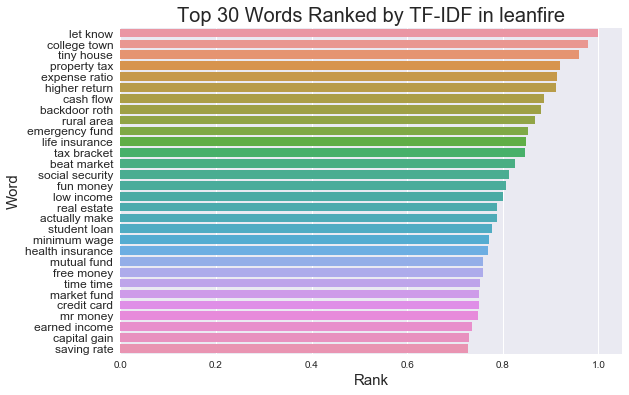

In [27]:
top_n = 30
top_features = Xtfidf_train_df.loc[1].max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 6))
plt.title(f'Top {top_n} Words Ranked by TF-IDF in leanfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

In [33]:
top_features_df = pd.DataFrame()
top_features_df['Bi-gram'] = top_features.index
top_features_df['TF-IDF Weight'] = top_features.values
top_features_df

,Bi-gram,TF-IDF Weight
0,let know,1.000000
1,college town,0.978223
2,tiny house,0.959976
3,property tax,0.920524
4,expense ratio,0.912464
5,higher return,0.911182
6,cash flow,0.885153
7,backdoor roth,0.880101
8,rural area,0.867759
9,emergency fund,0.851943


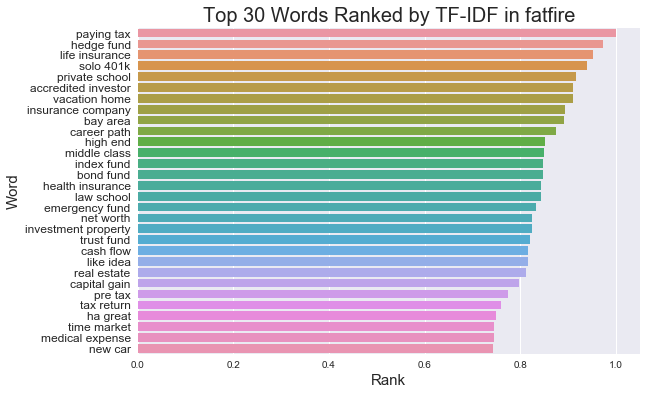

In [34]:
top_n = 30
top_features_tfidf = Xtfidf_train_df.loc[0].max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 6))
plt.title(f'Top {top_n} Words Ranked by TF-IDF in fatfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features_tfidf.values, top_features_tfidf.index)
plt.show()

In [35]:
top_features_tfidf_df = pd.DataFrame()
top_features_tfidf_df['Bi-gram'] = top_features_tfidf.index
top_features_tfidf_df['TF-IDF Weight'] = top_features_tfidf.values
top_features_tfidf_df

,Bi-gram,TF-IDF Weight
0,paying tax,1.000000
1,hedge fund,0.972016
2,life insurance,0.951363
3,solo 401k,0.939952
4,private school,0.915505
5,accredited investor,0.911096
6,vacation home,0.910590
7,insurance company,0.893599
8,bay area,0.892027
9,career path,0.874834


### Model

In [425]:
lr = LogisticRegression()

lr.fit(Xtfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Interpret Coefficients

In [426]:
lr_feature_coefs = pd.DataFrame({'feature' : Xtfidf_train_df.columns, 'coef' : lr.coef_[0]})
lr_feature_coefs = lr_feature_coefs.sort_values(by = 'coef', ascending = False)
lr_feature_coefs.head(10)

,feature,coef
853,traditional ira,1.712582
744,social security,1.710186
209,early retirement,1.659130
724,save money,1.640279
774,student loan,1.543807
144,cost living,1.477000
715,roth ira,1.339641
212,emergency fund,1.299896
568,new job,1.251590
513,minimum wage,1.229452


In [428]:
np.exp(1.712582)

5.543255702061676

Since the features were transformed by **TF-IDF**, it is not as obvious how the coefficient exactly increases to the odds that a post belongs to class `y=1`.

### Classification Metrics

In [424]:
cross_val_score(lr, Xtfidf_train, y_train, cv = kf).mean()

0.8128787878787879

In [372]:
lr.score(Xtfidf_train, y_train)

0.956060606060606

In [373]:
lr.score(Xtfidf_test, y_test)

0.8431818181818181

In [374]:
cross_val_score(lr, Xtfidf_train, y_train, cv = kf).mean()

0.8371212121212122

Since the test score is 6% lower than the training score, the model is overfit.

In [375]:
cm = ClassificationMetrics()
cm.fit(lr.predict(Xtfidf_train), y_train)
cm.describe()

,Metric
Accuracy,0.956061
False Negative Rate,0.025878
False Positive Rate,0.025878
Misclassification,0.043939
Negative Predictive Value,0.922942
Precision,0.981308
Sensitivity,0.943517
Specificity,0.974122


In [376]:
cm = ClassificationMetrics()
cm.fit(lr.predict(Xtfidf_test), y_test)
cm.describe()

,Metric
Accuracy,0.843182
False Negative Rate,0.114650
False Positive Rate,0.114650
Misclassification,0.156818
Negative Predictive Value,0.731579
Precision,0.928000
Sensitivity,0.819788
Specificity,0.885350
